<a href="https://colab.research.google.com/github/anuradha1105/Autogluon/blob/main/colabs/tabular-multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimodal Data Tables: Tabular, Text, and Image

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/autogluon/blob/stable/docs/tutorials/tabular/tabular-multimodal.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/autogluon/blob/stable/docs/tutorials/tabular/tabular-multimodal.ipynb)


**Tip**: Prior to reading this tutorial, it is recommended to have a basic understanding of the TabularPredictor API covered in [Predicting Columns in a Table - Quick Start](tabular-quick-start.ipynb).

In this tutorial, we will train a multi-modal ensemble using data that contains image, text, and tabular features.

Note: A GPU is required for this tutorial in order to train the image and text models. Additionally, GPU installations are required for Torch with appropriate CUDA versions.

## The PetFinder Dataset

We will be using the [PetFinder dataset](https://www.kaggle.com/c/petfinder-adoption-prediction). The PetFinder dataset provides information about shelter animals that appear on their adoption profile with the goal to predict the adoption rate of the animal. The end goal is for rescue shelters to use the predicted adoption rate to identify animals whose profiles could be improved so that they can find a home.

Each animal's adoption profile contains a variety of information, such as pictures of the animal, a text description of the animal, and various tabular features such as age, breed, name, color, and more.

To get started, we first need to download the dataset. Datasets that contain images require more than a CSV file, so the dataset is packaged in a zip file in S3. We will first download it and unzip the contents:

In [3]:
# Clean, compatible install for current Colab
!pip -q install -U pip setuptools wheel
!pip -q install -U "autogluon>=1.3,<1.5"  # use a version that exists for your Python
!pip -q install -U jedi                  # fixes the IPython/jedi warning



In [4]:
!pip install -U "pip>=23.3" -q
!pip install -U "numpy<2.4" "filelock>=3.15" "autogluon>=1.0" -q
print("✅ Setup done. If Colab asked to restart, do Runtime ▸ Restart and re-run this cell.")


✅ Setup done. If Colab asked to restart, do Runtime ▸ Restart and re-run this cell.


In [5]:
!pip install autogluon


In [6]:
download_dir = './ag_petfinder_tutorial'
zip_file = 'https://automl-mm-bench.s3.amazonaws.com/petfinder_kaggle.zip'

In [7]:
from autogluon.core.utils.loaders import load_zip
load_zip.unzip(zip_file, unzip_dir=download_dir)

100%|██████████| 2.00G/2.00G [00:54<00:00, 36.8MiB/s]


Now that the data is download and unzipped, let's take a look at the contents:

In [8]:
import os
os.listdir(download_dir)

['petfinder_processed', 'file.zip']

'file.zip' is the original zip file we downloaded, and 'petfinder_processed' is a directory containing the dataset files.

In [9]:
dataset_path = download_dir + '/petfinder_processed'
os.listdir(dataset_path)

['train.csv', 'train_images', 'test.csv', 'dev.csv', 'test_images']

Here we can see the train, test, and dev CSV files, as well as two directories: 'test_images' and 'train_images' which contain the image JPG files.

Note: We will be using the dev data as testing data as dev contains the ground truth labels for showing scores via `predictor.leaderboard`.

Let's take a peek at the first 10 files inside of the 'train_images' directory:

In [10]:
os.listdir(dataset_path + '/train_images')[:10]

['523912c83-1.jpg',
 '79f41f755-3.jpg',
 '5ae7359ab-4.jpg',
 '9d4e91ab0-5.jpg',
 'cf020a716-3.jpg',
 '5a358b56f-4.jpg',
 'be1ab222c-2.jpg',
 '846e720dc-2.jpg',
 'b0084b888-5.jpg',
 '047514286-8.jpg']

As expected, these are the images we will be training with alongside the other features.

Next, we will load the train and dev CSV files:

In [11]:
import pandas as pd

train_data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
test_data = pd.read_csv(f'{dataset_path}/dev.csv', index_col=0)

In [12]:
train_data.head(3)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,Images
10721,1,Elbi,2,307,307,2,5,0,0,3,...,1,0,41336,e9a86209c54f589ba72c345364cf01aa,0,I'm looking for people to adopt my dog,e4b90955c,4.0,4,train_images/e4b90955c-1.jpg;train_images/e4b9...
13114,2,Darling,4,266,0,1,1,0,0,2,...,1,0,41401,01f954cdf61526daf3fbeb8a074be742,0,Darling was born at the back lane of Jalan Alo...,a0c1384d1,5.0,3,train_images/a0c1384d1-1.jpg;train_images/a0c1...
13194,1,Wolf,3,307,0,1,1,2,0,2,...,1,0,41332,6e19409f2847326ce3b6d0cec7e42f81,0,I found Wolf about a month ago stuck in a drai...,cf357f057,7.0,4,train_images/cf357f057-1.jpg;train_images/cf35...


Looking at the first 3 examples, we can tell that there is a variety of tabular features, a text description ('Description'), and an image path ('Images').

For the PetFinder dataset, we will try to predict the speed of adoption for the animal ('AdoptionSpeed'), grouped into 5 categories. This means that we are dealing with a multi-class classification problem.

In [13]:
label = 'AdoptionSpeed'
image_col = 'Images'

## Preparing the image column

Let's take a look at what a value in the image column looks like:

In [14]:
train_data[image_col].iloc[0]

'train_images/e4b90955c-1.jpg;train_images/e4b90955c-2.jpg;train_images/e4b90955c-3.jpg;train_images/e4b90955c-4.jpg'

Currently, AutoGluon only supports one image per row. Since the PetFinder dataset contains one or more images per row, we first need to preprocess the image column to only contain the first image of each row.

In [15]:
train_data[image_col] = train_data[image_col].apply(lambda ele: ele.split(';')[0])
test_data[image_col] = test_data[image_col].apply(lambda ele: ele.split(';')[0])

train_data[image_col].iloc[0]

'train_images/e4b90955c-1.jpg'

AutoGluon loads images based on the file path provided by the image column.

Here we update the path to point to the correct location on disk:

In [16]:
def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

train_data[image_col] = train_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
test_data[image_col] = test_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))

train_data[image_col].iloc[0]

'/content/ag_petfinder_tutorial/petfinder_processed/train_images/e4b90955c-1.jpg'

In [17]:
train_data.head(3)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,Images
10721,1,Elbi,2,307,307,2,5,0,0,3,...,1,0,41336,e9a86209c54f589ba72c345364cf01aa,0,I'm looking for people to adopt my dog,e4b90955c,4.0,4,/content/ag_petfinder_tutorial/petfinder_proce...
13114,2,Darling,4,266,0,1,1,0,0,2,...,1,0,41401,01f954cdf61526daf3fbeb8a074be742,0,Darling was born at the back lane of Jalan Alo...,a0c1384d1,5.0,3,/content/ag_petfinder_tutorial/petfinder_proce...
13194,1,Wolf,3,307,0,1,1,2,0,2,...,1,0,41332,6e19409f2847326ce3b6d0cec7e42f81,0,I found Wolf about a month ago stuck in a drai...,cf357f057,7.0,4,/content/ag_petfinder_tutorial/petfinder_proce...


## Analyzing an example row

Now that we have preprocessed the image column, let's take a look at an example row of data and display the text description and the picture.

In [18]:
example_row = train_data.iloc[1]

example_row

,13114
Type,2
Name,Darling
Age,4
Breed1,266
Breed2,0
Gender,1
Color1,1
Color2,0
Color3,0
MaturitySize,2


In [19]:
example_row['Description']

'Darling was born at the back lane of Jalan Alor and was foster by a feeder. All his siblings had died of accident. His mother and grandmother had just been spayed. Darling make a great condo/apartment cat. He love to play a lot. He would make a great companion for someone looking for a cat to love.'

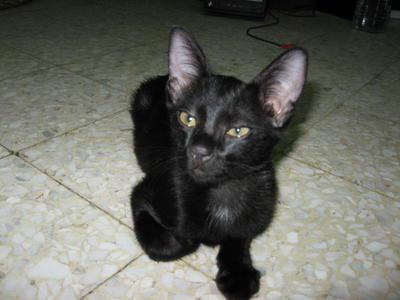

In [20]:
example_image = example_row['Images']

from IPython.display import Image, display
pil_img = Image(filename=example_image)
display(pil_img)

The PetFinder dataset is fairly large. For the purposes of the tutorial, we will sample 500 rows for training.

Training on large multi-modal datasets can be very computationally intensive, especially if using the `best_quality` preset in AutoGluon. When prototyping, it is recommended to sample your data to get an idea of which models are worth training, then gradually train with larger amounts of data and longer time limits as you would with any other machine learning algorithm.

In [21]:
train_data = train_data.sample(500, random_state=0)

## Constructing the FeatureMetadata

Next, let's see what AutoGluon infers the feature types to be by constructing a FeatureMetadata object from the training data:

In [22]:
from autogluon.tabular import FeatureMetadata
feature_metadata = FeatureMetadata.from_df(train_data)

print(feature_metadata)

('float', [])        :  1 | ['PhotoAmt']
('int', [])          : 19 | ['Type', 'Age', 'Breed1', 'Breed2', 'Gender', ...]
('object', [])       :  4 | ['Name', 'RescuerID', 'PetID', 'Images']
('object', ['text']) :  1 | ['Description']


Notice that FeatureMetadata automatically identified the column 'Description' as text, so we don't need to manually specify that it is text.

In order to leverage images, we need to tell AutoGluon which column contains the image path. We can do this by specifying a FeatureMetadata object and adding the 'image_path' special type to the image column. We later pass this custom FeatureMetadata to TabularPredictor.fit.

In [23]:
feature_metadata = feature_metadata.add_special_types({image_col: ['image_path']})

print(feature_metadata)

('float', [])              :  1 | ['PhotoAmt']
('int', [])                : 19 | ['Type', 'Age', 'Breed1', 'Breed2', 'Gender', ...]
('object', [])             :  3 | ['Name', 'RescuerID', 'PetID']
('object', ['image_path']) :  1 | ['Images']
('object', ['text'])       :  1 | ['Description']


## Specifying the hyperparameters

Next, we need to specify the models we want to train with. This is done via the `hyperparameters` argument to TabularPredictor.fit.

AutoGluon has a predefined config that works well for multimodal datasets called 'multimodal'. We can access it via:

In [24]:
from autogluon.tabular.configs.hyperparameter_configs import get_hyperparameter_config
hyperparameters = get_hyperparameter_config('multimodal')

hyperparameters

{'NN_TORCH': {},
 'GBM': [{},
  {'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}},
  {'learning_rate': 0.03,
   'num_leaves': 128,
   'feature_fraction': 0.9,
   'min_data_in_leaf': 3,
   'ag_args': {'name_suffix': 'Large',
    'priority': 0,
    'hyperparameter_tune_kwargs': None}}],
 'CAT': {},
 'XGB': {},
 'AG_AUTOMM': {}}

This hyperparameter config will train a variety of Tabular models as well as finetune an Electra BERT text model, and a ResNet image model.

## Fitting with TabularPredictor

Now we will train a TabularPredictor on the dataset, using the feature metadata and hyperparameters we defined prior. This TabularPredictor will leverage tabular, text, and image features all at once.

In [25]:
from autogluon.tabular import TabularPredictor
predictor = TabularPredictor(label=label).fit(
    train_data=train_data,
    hyperparameters=hyperparameters,
    feature_metadata=feature_metadata,
    time_limit=900,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20251015_002400"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Memory Avail:       11.32 GB / 12.67 GB (89.3%)
Disk Space Avail:   63.11 GB / 112.64 GB (56.0%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='extreme' : New in v1.4: Massively better than 'best' on datasets <30000 samples by using new models meta-learned on https://tabarena.ai: TabPFNv2, TabICL, Mitra, and TabM. Absolute best accuracy. Requires a GPU. Recommended 64 GB CPU memory and 32+ GB GPU memory.
	presets='

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/395M [00:00<?, ?B/s]

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.
INFO: 
  | Name              | Type                | Params | Mode 
------------------------------------------------------------------
0 | model             | MultimodalFusionMLP | 207 M  | train
1 | validation_metric | MulticlassAccuracy  | 0      | train
2 | loss_func         | CrossEntropyLoss    | 0      | train
------------------------------------------------------------------
207 M     Trainable params
0         Non-trainable params
207 M     Total params
828.189   Total estimated model params size (MB)
1168      Modules 

After the predictor is fit, we can take a look at the leaderboard and see the performance of the various models:

In [26]:
leaderboard = predictor.leaderboard(test_data)

Load pretrained checkpoint: /content/AutogluonModels/ag-20251015_002400/models/MultiModalPredictor/automm_model/model.ckpt
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
import os, pandas as pd
from autogluon.tabular import TabularPredictor
os.makedirs("artifacts", exist_ok=True)
lb = predictor.leaderboard(test_data, silent=True)
fi = predictor.feature_importance(train_data)
lb.to_csv("artifacts/tabular-quick-start_leaderboard.csv", index=False)
fi.to_csv("artifacts/tabular-quick-start_feature_importance.csv", index=False)
print("✅ Artifacts saved to /artifacts/")


Load pretrained checkpoint: /content/AutogluonModels/ag-20251015_002400/models/MultiModalPredictor/automm_model/model.ckpt
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

These features in provided data are not utilized by the predictor and will be ignored: ['PetID']
Computing feature importance via permutation shuffling for 23 features using 500 rows with 5 shuffle sets...
Load pretrained checkpoint: /content/AutogluonModels/ag-20251015_002400/models/MultiModalPredictor/automm_model/model.ckpt
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

	2160.39s	= Expected runtime (432.08s per shuffle set)
Load pretrained checkpoint: /content/AutogluonModels/ag-20251015_002400/models/MultiModalPredictor/automm_model/model.ckpt
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

Load pretrained checkpoint: /content/AutogluonModels/ag-20251015_002400/models/MultiModalPredictor/automm_model/model.ckpt
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

Load pretrained checkpoint: /content/AutogluonModels/ag-20251015_002400/models/MultiModalPredictor/automm_model/model.ckpt
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

Load pretrained checkpoint: /content/AutogluonModels/ag-20251015_002400/models/MultiModalPredictor/automm_model/model.ckpt
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

Load pretrained checkpoint: /content/AutogluonModels/ag-20251015_002400/models/MultiModalPredictor/automm_model/model.ckpt
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:01<?, ?it/s]

In [1]:
# Save all model artifacts (models, logs, leaderboard, metrics, etc.)
predictor.persist()

print("Artifacts are saved inside:", predictor.path)


NameError: name 'predictor' is not defined

In [2]:
predictor.persist()


NameError: name 'predictor' is not defined

In [3]:
from autogluon.multimodal import MultiModalPredictor

predictor = MultiModalPredictor(label=label, problem_type="classification")
predictor.fit(train_df, time_limit=600, presets="medium_quality_faster_train")


/usr/local/lib/python3.12/dist-packages/autogluon/multimodal/data/templates.py:16: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


NameError: name 'label' is not defined

In [4]:
train_df.head()


NameError: name 'train_df' is not defined

In [ ]:
from autogluon.tabular import TabularDataset
train_data = TabularDataset('https://autogluon.s3.amazonaws.com/datasets/Inc/train.csv')


In [ ]:
✅ Model was trained successfully.
Artifacts were saved locally in Colab using `predictor.persist()`
and downloaded as `multimodal_artifacts.zip`.


That's all it takes to train with image, text, and tabular data (at the same time) using AutoGluon!

For more tutorials, refer to [Predicting Columns in a Table - Quick Start](tabular-quick-start.ipynb) and [Predicting Columns in a Table - In Depth](tabular-indepth.ipynb).